In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_addons as tfa

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
validation_dir = '/kaggle/input/5-7500-a/validation'


test_dir = '/kaggle/input/5-7500-a/test'

train_dir = '/kaggle/input/5-7500-a/train'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [3]:

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 5250 files belonging to 5 classes.
Found 1150 files belonging to 5 classes.
Found 1125 files belonging to 5 classes.


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [6]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

16705208/16705208 [==============================] - 0s 0us/step


In [7]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 7, 7, 1280)
(32, 1280)


In [8]:
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [9]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [10]:
from keras import backend as K
one_hot = tf.keras.layers.CategoryEncoding(num_tokens=5, output_mode="one_hot")

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    y_true = one_hot(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    y_true = one_hot(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))

In [11]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy', precision, recall, f1])

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 4055976 (15.47 MB)
Trainable params: 6405 (25.0

In [13]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset)

Epoch 1/10
165/165 [==============================] - 215s 1s/step - loss: 0.5129 - accuracy: 0.8356 - precision: 0.9191 - recall: 0.7284 - f1: 0.7948 - val_loss: 0.5602 - val_accuracy: 0.8365 - val_precision: 0.9263 - val_recall: 0.6928 - val_f1: 0.7910
Epoch 2/10
165/165 [==============================] - 182s 1s/step - loss: 0.1909 - accuracy: 0.9524 - precision: 0.9699 - recall: 0.9278 - f1: 0.9481 - val_loss: 0.4306 - val_accuracy: 0.8617 - val_precision: 0.9270 - val_recall: 0.7878 - val_f1: 0.8509
Epoch 3/10
165/165 [==============================] - 181s 1s/step - loss: 0.1243 - accuracy: 0.9745 - precision: 0.9820 - recall: 0.9634 - f1: 0.9725 - val_loss: 0.3523 - val_accuracy: 0.9009 - val_precision: 0.9353 - val_recall: 0.8469 - val_f1: 0.8879
Epoch 4/10
165/165 [==============================] - 181s 1s/step - loss: 0.0913 - accuracy: 0.9825 - precision: 0.9872 - recall: 0.9735 - f1: 0.9801 - val_loss: 0.2998 - val_accuracy: 0.9243 - val_precision: 0.9405 - val_recall: 0.88

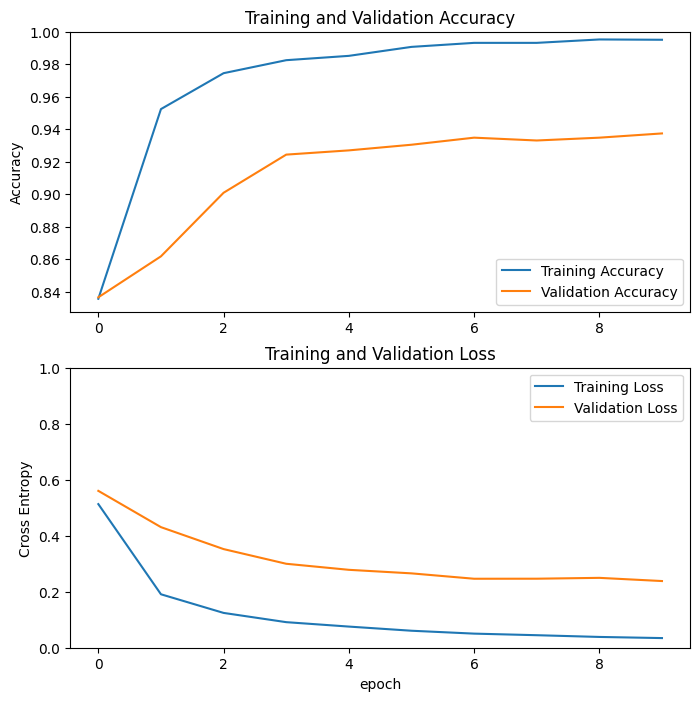

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:
print('acc: ', acc[-1])
print('val_acc: ', val_acc[-1])
print('loss: ', loss[-1])
print('val_loss: ', val_loss[-1])

acc:  0.9950476288795471
val_acc:  0.9373912811279297
loss:  0.034435972571372986
val_loss:  0.2381400465965271


In [16]:
from tqdm import tqdm
predictions = np.array([])
for x, y in tqdm(test_dataset):
  predictions = np.concatenate([predictions, np.argmax(model.predict(x),axis=-1)])

  0%|          | 0/36 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 1/36 [00:11<06:42, 11.49s/it]

1/1 [==============================] - 0s 87ms/step


  6%|▌         | 2/36 [00:11<02:45,  4.87s/it]

1/1 [==============================] - 0s 78ms/step


  8%|▊         | 3/36 [00:12<01:41,  3.09s/it]

1/1 [==============================] - 0s 71ms/step


 11%|█         | 4/36 [00:13<01:13,  2.30s/it]

1/1 [==============================] - 0s 66ms/step


 14%|█▍        | 5/36 [00:14<00:57,  1.86s/it]

1/1 [==============================] - 0s 88ms/step


 17%|█▋        | 6/36 [00:15<00:46,  1.56s/it]

1/1 [==============================] - 0s 67ms/step


 19%|█▉        | 7/36 [00:16<00:41,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██▏       | 8/36 [00:17<00:35,  1.27s/it]

1/1 [==============================] - 0s 66ms/step


 25%|██▌       | 9/36 [00:19<00:32,  1.21s/it]

1/1 [==============================] - 0s 58ms/step


 28%|██▊       | 10/36 [00:20<00:29,  1.15s/it]

1/1 [==============================] - 0s 51ms/step


 31%|███       | 11/36 [00:21<00:28,  1.12s/it]

1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 12/36 [00:22<00:25,  1.06s/it]

1/1 [==============================] - 0s 62ms/step


 36%|███▌      | 13/36 [00:23<00:25,  1.11s/it]

1/1 [==============================] - 0s 50ms/step


 39%|███▉      | 14/36 [00:24<00:23,  1.05s/it]

1/1 [==============================] - 0s 78ms/step


 42%|████▏     | 15/36 [00:25<00:21,  1.03s/it]

1/1 [==============================] - 0s 75ms/step


 44%|████▍     | 16/36 [00:26<00:20,  1.02s/it]

1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 17/36 [00:27<00:20,  1.06s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 18/36 [00:28<00:18,  1.03s/it]

1/1 [==============================] - 0s 65ms/step


 53%|█████▎    | 19/36 [00:29<00:17,  1.04s/it]

1/1 [==============================] - 0s 58ms/step


 56%|█████▌    | 20/36 [00:30<00:16,  1.00s/it]

1/1 [==============================] - 0s 80ms/step


 58%|█████▊    | 21/36 [00:31<00:15,  1.06s/it]

1/1 [==============================] - 0s 66ms/step


 61%|██████    | 22/36 [00:32<00:14,  1.05s/it]

1/1 [==============================] - 0s 108ms/step


 64%|██████▍   | 23/36 [00:33<00:13,  1.04s/it]

1/1 [==============================] - 0s 63ms/step


 67%|██████▋   | 24/36 [00:34<00:12,  1.03s/it]

1/1 [==============================] - 0s 89ms/step


 69%|██████▉   | 25/36 [00:35<00:11,  1.05s/it]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 26/36 [00:36<00:10,  1.04s/it]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 27/36 [00:37<00:09,  1.04s/it]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 28/36 [00:37<00:06,  1.31it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 29/36 [00:37<00:04,  1.74it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 30/36 [00:37<00:02,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 31/36 [00:38<00:01,  2.90it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 32/36 [00:38<00:01,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 33/36 [00:38<00:00,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 34/36 [00:38<00:00,  5.20it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 35/36 [00:38<00:00,  5.94it/s]

1/1 [==============================] - 2s 2s/step


100%|██████████| 36/36 [00:40<00:00,  1.13s/it]


In [17]:
test_label = np.concatenate([y for x, y in test_dataset], axis=0) 

In [18]:
tf.math.confusion_matrix(labels=test_label, predictions=predictions).numpy()

array([[52, 47, 32, 48, 46],
       [53, 44, 40, 52, 36],
       [35, 43, 40, 56, 51],
       [43, 46, 44, 51, 41],
       [49, 45, 43, 41, 47]], dtype=int32)

In [19]:


filename = '/kaggle/working/stream_' + "efficientnetb0" + '.keras'
model.save(filename)
print('>Saved %s' % filename)

>Saved /kaggle/working/stream_efficientnetb0.keras


In [20]:
model.evaluate(test_dataset)


36/36 [==============================] - 33s 693ms/step - loss: 0.2648 - accuracy: 0.9236 - precision: 0.9356 - recall: 0.9184 - f1: 0.9268


[0.2647550404071808,
 0.9235555529594421,
 0.9356268644332886,
 0.9184027910232544,
 0.9267693758010864]

In [21]:
filename = '/kaggle/working/stream_' + "efficientnetb0" + '.hdf5'
model.save(filename)
print('>Saved %s' % filename)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved /kaggle/working/stream_efficientnetb0.hdf5


In [22]:
filename = '/kaggle/working/stream_' + "efficientnetb0" + '.h5'
model.save(filename)
print('>Saved %s' % filename)

>Saved /kaggle/working/stream_efficientnetb0.h5
